In [1]:
import numpy as np
from matplotlib  import pyplot as plt
from scipy.spatial import Delaunay
import networkx as nx
import scipy.linalg as scla
import time
import matplotlib.gridspec as gridspec

# just a bunch of imports and silly things 

#from matplotlib import rc **this made cesar crash**
#rc('text', usetex=True)
#rc('font', size=16)
#rc('legend', fontsize=13)
#rc('text.latex', preamble=r'\usepackage{cmbright}')

def createDelaunayGraph(NS,rseed,r_c,del_x):
    np.random.seed(rseed)
    xm, ym = np.meshgrid(np.arange(1, NS+1), np.arange(1, NS+1))
    X = np.vstack((xm.flatten(), ym.flatten())).T
    N = X.shape[0]
    X = X + del_x * 2 * (0.5 - np.random.rand(N, 2))
    
    DT = Delaunay(X)
    ET = np.empty((0, 2), dtype=int)
    for T in DT.simplices:
        ET = np.vstack((ET, [T[0], T[1]], [T[1], T[2]], [T[0], T[2]]))
    
    ET=np.sort(ET)
    R=np.linalg.norm(X[ET[:, 0], :] - X[ET[:, 1], :],axis=1)
    EN=ET[R<r_c,:]
    A = np.zeros((N, N))
    A[EN[:,0],EN[:,1]]=1
    
    
    G = nx.Graph(A)
    E=np.array(G.edges)
    
    return N,G,X,E

def createSquareGraph(NS,rseed,r_c,del_x, periodic = False):
    np.random.seed(rseed)
    xm, ym = np.meshgrid(np.arange(1, NS+1), np.arange(1, NS+1))
    X = np.vstack((xm.flatten(), ym.flatten())).T
    N = X.shape[0]
    
    
    T=np.tile(X,(N,1,1))
    T2=np.moveaxis(T,0,1)
    TD=T-T2
    if periodic:
        box_length = NS
        TD = (TD/box_length)
        TDN=TD-np.rint(TD)
        TDR=box_length*TDN
    distances_all = np.linalg.norm(TDR,axis=2)
    E1=np.array(np.where(distances_all<r_c))
    E=np.transpose(E1[:,E1[0]>E1[1]])
    
    G = nx.Graph()
    G.add_nodes_from(range(N))
    G.add_edges_from(E)
    E=np.array(G.edges)
    X = X+ del_x * 2 * (0.5 - np.random.rand(N, 2))
    if periodic:
        return N,G,X,E,box_length
    else:
        return N,G,X,E

def createLineGraph(NS,rseed,r_c,del_x, periodic = False):
    np.random.seed(rseed)
    xm, ym = np.meshgrid(np.arange(1, NS+1), np.arange(1, 2))
    X = np.vstack((xm.flatten(), ym.flatten())).T
    N = X.shape[0]
    
    
    T=np.tile(X,(N,1,1))
    T2=np.moveaxis(T,0,1)
    TD=T-T2
    if periodic:
        box_length = NS
        TD = (TD/box_length)
        TDN=TD-np.rint(TD)
        TDR=box_length*TDN
    distances_all = np.linalg.norm(TDR,axis=2)
    E1=np.array(np.where(distances_all<r_c))
    E=np.transpose(E1[:,E1[0]>E1[1]])
    
    G = nx.Graph()
    G.add_nodes_from(range(N))
    G.add_edges_from(E)
    E=np.array(G.edges)
    X = X+ del_x * 2 * (0.5 - np.random.rand(N, 2))
    if periodic:
        return N,G,X,E,box_length
    else:
        return N,G,X,E

def getBondImportance(X,C,V,D,D_range):
    modes = np.where((D > D_range[0]) & (D < D_range[1]))[0]
    delta_E=C.T@V
    EC=delta_E[:,modes]
    bondImportance=np.mean(np.abs(EC),axis=1)
    return bondImportance/np.max(bondImportance)

def createCompatibility(N,X,E, box_length = None, periodic = False):
    
    N_b = E.shape[0]
    C = np.zeros((2 * N, N_b))
    
    for i in range(N_b):
        b_vec = X[E[i, 0], :] - X[E[i, 1], :]
        if periodic:
            b_vec_scaled = b_vec/box_length
            b_vec = box_length*(b_vec_scaled - np.rint(b_vec_scaled))
        b_vec = b_vec / np.linalg.norm(b_vec)
        for ki in range(2):
            j = E[i, ki]
            xind = 2 * j 
            C[xind:xind + 2, i] = ((-1) ** ki) * b_vec

    return C

def createSpringConstants(X,E,k_1, box_length=None, periodic = False):
    #k_1 is the spring constant for a spring of unit length
    displacements=X[E[:,0],:]-X[E[:,1],:]
    if periodic:
        displacements_scaled = displacements/box_length
        displacements = box_length*(displacements_scaled 
                                    - np.rint(displacements_scaled))
    distance=np.linalg.norm(displacements,axis=1)
    return k_1/distance,distance

def getForbiddenModes(C, k, M, w_c, dw):
    kd = np.diag(np.squeeze(k))
    K = C @ kd @ C.T
    DMAT = np.linalg.inv(M) @ K
    D, V = scla.eig(DMAT,overwrite_a=True)
    D = np.real(D)
    w=np.sqrt(np.abs(D))
    forbidden_states=np.sum(np.logical_and(w>w_c-dw/2,w<w_c+dw/2))
    V=np.real(V)
    return D, V,forbidden_states

def ageSprings(k_old,X,C,V,D,D_range,ageing_rate):
    bond_importance=getBondImportance(X,C,V,D,D_range)
    bond_importance_centered=bond_importance-np.mean(bond_importance)
    bond_importance_normalized=bond_importance_centered/np.max(np.abs(bond_importance_centered))

    k_new=k_old*(1+2*ageing_rate*bond_importance_normalized)
    return k_new
    
def optimizeAgeing(C, k, M, w_c, dw, N_trials,ageing_rate,success_frac):
    w_range=[w_c-dw/2,w_c+dw/2]
    D_range = [x**2 for x in w_range]
    D, V, forbidden_states_initial = getForbiddenModes(C, k, M, w_c, dw)
    if forbidden_states_initial==0:
        return k,1,0
    for trial in range(1, N_trials+1):
        k=ageSprings(k,X,C,V,D,D_range,ageing_rate)
    
        D, V, forbidden_states = getForbiddenModes(C, k, M, w_c, dw)
        print(trial,forbidden_states)
    
        if forbidden_states<=success_frac*forbidden_states_initial:
            
            return k, 1,trial
    
    return k,0,trial

def plotmodeM(G, X, V, mode):
    N = G.number_of_nodes()
    V=np.real(V)
    X_ = X[:, 0]
    Y_ = X[:, 1]
    dx = V[0:2 * N:2, mode]
    dy = V[1:2 * N:2, mode]
    m=np.fromiter(nx.get_node_attributes(G,'Mass').values(),dtype=float)
    MSizes =10 * m / np.max(m)
    # print(MSizes)
    LWidths = 2
    nx.draw(G, pos=X, node_size=2*m, width=LWidths, node_color='k', edge_color='k')
    for i in range(N):
        plt.arrow(X_[i], Y_[i], dx[i], dy[i], head_width=0.15, head_length=0.15, fc='r', ec='r')
    # plt.axis('equal')
    plotlimits = [min(X_.min(), Y_.min()) - 2, max(X_.max(), Y_.max()) + 2]
    plt.xlim(min(X.ravel()) - 2, max(X.ravel()) + 2)
    plt.ylim(min(X.ravel()) - 2, max(X.ravel()) + 2)
    plt.axis('equal')
    plt.axis('off')


def plotmodeD(G,X,V,mode):
    N = G.number_of_nodes()

    X2=X+np.stack((V[0:2*N:2,mode],V[1:2*N:2,mode])).T
    pos2 = dict(zip(range(G.number_of_nodes()), X2))
    nx.draw(G, pos2, node_size=10, node_color="blue")
    
    plt.xlim(min(X.ravel()) - 2, max(X.ravel()) + 2)
    plt.ylim(min(X.ravel()) - 2, max(X.ravel()) + 2)
    plt.axis('equal')
    plt.axis('off')
    
def plotmodeE(G,X,C,V,mode):
    X_ = X[:, 0]
    Y_ = X[:, 1]
    delta_E=C.T@V
    EC=delta_E[:,mode]
    pos = dict(zip(range(G.number_of_nodes()), X))
    edges=nx.draw_networkx_edges(G, pos, edge_color=EC,edge_cmap=plt.cm.bwr)
    plt.colorbar(edges)
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color='k',alpha=1)
    
    plotlimits = [min(X_.min(), Y_.min()) - 2, max(X_.max(), Y_.max()) + 2]
    plt.axis('equal')
    plt.xlim(plotlimits)
    plt.ylim(plotlimits)
    
def multiplots(G,X,C,V,d,d_range):
    modes = np.where((d > d_range[0]) & (d < d_range[1]))[0]
    N_modes = len(modes)
    Nrows = 4
    Ncols = np.ceil(N_modes / Nrows).astype(int)
    
    # Plotting modes with colored nodes and arrows
    fig1 = plt.figure(figsize=(10, 10))
    gs1 = gridspec.GridSpec(Ncols, Nrows, figure=fig1, wspace=0.2, hspace=0.2)
    for i, mode in enumerate(modes):
        ax = plt.subplot(gs1[i])
        plotmodeD(G, X,V, mode)
        ax.set_aspect('equal')

    fig2 = plt.figure(figsize=(10, 10))
    gs2 = gridspec.GridSpec(Ncols, Nrows, figure=fig2, wspace=0.2, hspace=0.2)
    for i, mode in enumerate(modes):
        ax = plt.subplot(gs2[i])
        plotmodeM(G, X, V, mode)
        ax.set_aspect('equal')
        
def plotmodeC(G, X, V, mode):
    N = X.shape[0]
    cmap = plt.cm.hsv(np.linspace(0, 1, 360))
    alpha = np.arctan2(V[1:2*N:2, mode], V[0:2*N:2, mode])
    idx = np.ceil(np.rad2deg(np.mod(alpha, 2*np.pi)))
    idx[idx == 0] = 360
    m=np.fromiter(nx.get_node_attributes(G,'Mass').values(),dtype=float)
    MSizes =20 * m / np.max(m)
    
    MX = np.column_stack([V[0:2*N:2, mode], V[1:2*N:2, mode]])
    MV = np.linalg.norm(MX, axis=1)
    MV = MV/max(MV)
    
    pos = {i: X[i, :] for i in range(N)}
    node_color = [cmap[int(idx[i]-1), :] * MV[i] for i in range(N)]
    
    
    nx.draw_networkx_edges(G, pos, edge_color='k')
    nx.draw_networkx_nodes(G, pos, node_size=MSizes, node_color=node_color, alpha=1)
    plt.xlim(min(X.ravel()) - 2, max(X.ravel()) + 2)
    plt.ylim(min(X.ravel()) - 2, max(X.ravel()) + 2)
    plt.axis('equal')
    plt.axis('off')
    plt.show()


def set_ticks(axis, min_val, max_val):
    ticks = np.linspace(min_val, max_val, 4)
    axis.set_xticks(ticks)
    axis.set_xticklabels([f'{tick:.2f}' for tick in ticks])

In [29]:
# Create N G X E C M

runseed=10324
np.random.seed(runseed)
N_runs=1000
seeds=np.random.randint(0,103653,size=((N_runs)))
N_trials=1000
dw=0.1
w_c=2.0
ageing_rate=0.01
success_frac=0.05
freq_range=[w_c-dw/2,w_c+dw/2]
D_range = [x**2 for x in freq_range]
F_stack=[]
#N,G,X,E,box_length = createSquareGraph(3, seeds[51], 1.42, 0.4, periodic = False)
#N,G,X,E,box_length = createLineGraph(3, seeds[51], 1.2, 0.0, periodic = True)
N,G,X,E = createDelaunayGraph(6, seeds[51], 1.62, 0.4)

k , L = createSpringConstants(X, E, 1, box_length= box_length, periodic=False)
m = np.ones(N)
m[1] = 1
mdict=dict(zip(range(N), m))
nx.set_node_attributes(G,mdict,'Mass')

C=createCompatibility(N,X,E,box_length=box_length,periodic=False)

m2 = np.zeros(2 * N)
m2[0:2 * N:2] = m
m2[1:2 * N:2] = m
M = np.diag(m2)

3 Forbidden States


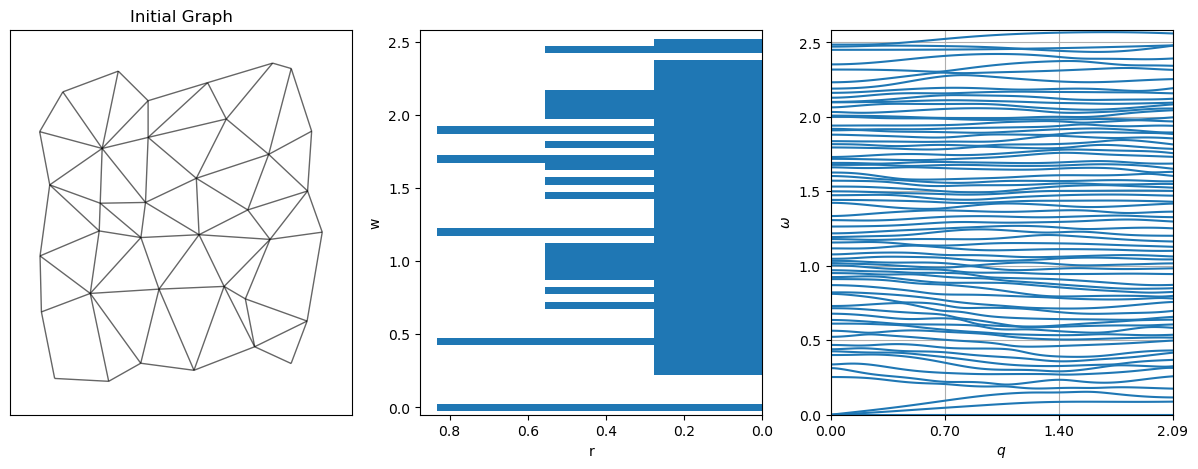

In [30]:
# plot graph and calculate dispersion curve
D, V, forbidden_states = getForbiddenModes(C, k, M, w_c, dw)

#fig = plt.figure(figsize=(18, 6))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plt.subplot(1, 3, 1)
pos = dict(zip(range(N), X))
edges=nx.draw_networkx_edges(G, pos, width=m, alpha=0.6,edge_color='k')
plt.title("Initial Graph")

plt.subplot(1,3, 2)
w1 = np.max(np.sqrt(np.abs(D))) + 0.1
plt.hist(np.sqrt(np.abs(D)), bins=np.arange(-0.025, w1, 0.05), density=True, orientation='horizontal')
plt.xlabel('r')
plt.ylabel('w')
plt.ylim([-0.05, w1])
plt.gca().invert_xaxis()
print(str(forbidden_states)+' Forbidden States')

plt.subplot(1,3, 3)

from dispersion import GetBranchedBro
disp = GetBranchedBro(box_length)
num_q_points = 100

qmax_x=2*np.pi/box_length
q_values_x = disp.create_q_path(0, qmax_x, 0, 0, num_q_points)
w = disp.get_dispersion(C, k, M, N, X, E, q_values_x)
for band in np.arange(0, 2 * N, 1):
    #plt.plot(q_values_x[:,0], np.sqrt(np.abs(w[:, band])), label=f'Band {band}', color="#1f77b4")
    plt.plot(q_values_x[:,0], w[:, band], label=f'Band {band}', color="#1f77b4")
    
set_ticks(axes[2], q_values_x[:, 0].min(), q_values_x[:, 0].max())
axes[2].set_xlim(q_values_x[:, 0].min(), q_values_x[:, 0].max())
plt.ylim([0,w1])
plt.xlabel('$q$')
plt.ylabel('$\omega$')
plt.grid(True)
plt.show()

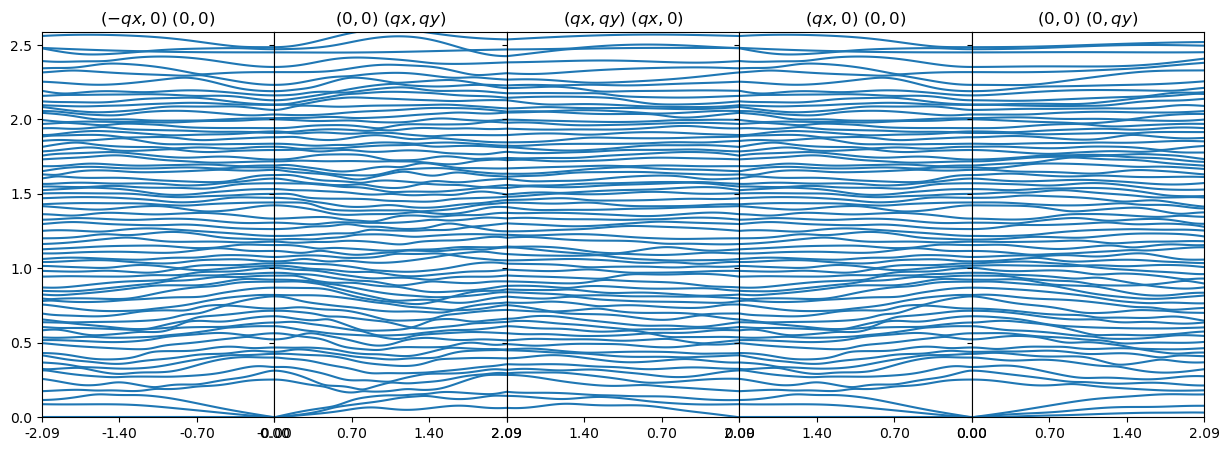

In [31]:
qmax_x = 2 * np.pi / box_length
qmax_y = 2 * np.pi / box_length

fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

# Plot for $(-qx, 0)~(0, 0)$
q_values_x = disp.create_q_path(0, qmax_x, 0, 0, num_q_points)
wx = disp.get_dispersion(C, k, M, N, X, E, q_values_x)
for band in np.arange(0, 2*N, 1):
    axes[0].plot(-q_values_x[:, 0], wx[:, band], color="#1f77b4")
axes[0].set_xlim(-q_values_x[:, 0].max(), -q_values_x[:, 0].min())
axes[0].set_title("$(-qx, 0)~(0, 0)$")
set_ticks(axes[0], -q_values_x[:, 0].max(), -q_values_x[:, 0].min())

# Plot for $(0, 0)~(qx, qy)$
q_values_xy = disp.create_q_path(0, qmax_x, 0, qmax_y, num_q_points)
wxy = disp.get_dispersion(C, k, M, N, X, E, q_values_xy)
for band in np.arange(0, 2*N, 1):
    axes[1].plot(q_values_xy[:, 1], wxy[:, band], color="#1f77b4")
axes[1].set_xlim(q_values_xy[:, 1].min(), q_values_xy[:, 1].max())
axes[1].set_title("$(0, 0)~(qx, qy)$")
set_ticks(axes[1], q_values_xy[:, 1].min(), q_values_xy[:, 1].max())

# Plot for $(qx, qy)~(qx, 0)$
q_values_y = disp.create_q_path(qmax_x, qmax_x, qmax_y, 0, num_q_points)
wy = disp.get_dispersion(C, k, M, N, X, E, q_values_y)
for band in np.arange(0, 2*N, 1):
    axes[2].plot(q_values_y[:, 1], wy[:, band], color="#1f77b4")
axes[2].set_xlim(q_values_y[:, 1].max(), q_values_y[:, 1].min())
axes[2].set_title("$(qx, qy)~(qx,0)$")
set_ticks(axes[2], q_values_y[:, 0].max(), q_values_y[:, 1].min())

# Plot for $(qx, 0)~(0, 0)$
q_values_x = disp.create_q_path(0, qmax_x, 0, 0, num_q_points)
wx = disp.get_dispersion(C, k, M, N, X, E, q_values_x)
for band in np.arange(0, 2*N, 1):
    axes[3].plot(q_values_x[:, 0], wx[:, band], color="#1f77b4")
axes[3].set_xlim(q_values_x[:, 0].max(), q_values_x[:, 0].min())
axes[3].set_title("$(qx, 0)~(0, 0)$")
set_ticks(axes[3], q_values_x[:, 0].max(), q_values_x[:, 0].min())

# Plot for $(0, 0)~(0, qy)$
q_values_y = disp.create_q_path(0, 0, 0, qmax_y, num_q_points)
wy = disp.get_dispersion(C, k, M, N, X, E, q_values_y)
for band in np.arange(0, 2*N, 1):
    axes[4].plot(q_values_y[:, 1], wy[:, band], color="#1f77b4")
axes[4].set_xlim(q_values_y[:, 1].min(), q_values_y[:, 1].max())
axes[4].set_title("$(0, 0)~(0, qy)$")
set_ticks(axes[4], q_values_y[:, 1].min(), q_values_y[:, 1].max())

plt.ylim([0, w1])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
